In [1]:
import pandas as pd
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = 14 

# 1.0) Datensätze Laden

In [2]:
alt_ges = pd.read_csv('./data/alter_geschlecht.csv', sep=',')
rest = pd.read_csv('./data/rest.csv', sep=';')
interesse = pd.read_csv("./data/interesse.csv", sep=',')

# 2.0) Vorläufige Datenanalyse

In [3]:
print("Alter-Geschlecht:", alt_ges.shape)
print("Rest:", rest.shape)
print("Interesse:", interesse.shape)

Alter-Geschlecht: (508146, 3)
Rest: (508146, 9)
Interesse: (381109, 2)


## 2.1) Duplizierte IDs

In [4]:
print("Alter-Geschlecht:", alt_ges['id'].duplicated().sum())
print("Rest:", rest['id'].duplicated().sum())
print("Interesse:", interesse['id'].duplicated().sum())

Alter-Geschlecht: 0
Rest: 0
Interesse: 0


## 2.2) Fehlwerte

In keinem Datensatz fehlen Werte. Bei fehlenden Werten sollten Imputationsmethoden wie die [multivariate Imputation (z.B. MICE)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) in Betracht gezogen werden.

In [5]:
print("Alter-Geschlecht:\n", alt_ges.isnull().mean(), "\n\n")
print("Rest:\n", rest.isnull().mean(), '\n\n')
print("Interesse:\n", interesse.isnull().mean())

Alter-Geschlecht:
 id            0.0
Geschlecht    0.0
Alter         0.0
dtype: float64 


Rest:
 Fahrerlaubnis      0.0
Regional_Code      0.0
Vorversicherung    0.0
Alter_Fzg          0.0
Vorschaden         0.0
Jahresbeitrag      0.0
Vertriebskanal     0.0
Kundentreue        0.0
id                 0.0
dtype: float64 


Interesse:
 id           0.0
Interesse    0.0
dtype: float64


# 3.0) Zusammenführung von Datensätzen

Da die Anzahl der eindeutigen IDs in den verschiedenen Datensätzen unterschiedlich ist, wird die Schnittmenge der IDs in den verschiedenen Datensätzen verwendet.

In [6]:
df_ = pd.merge(interesse, alt_ges, on='id', how='inner').merge(rest, on='id', how='inner').sort_values(by='id').set_index('id')  # id als Index setzen

Der zusammengeführte Datensatz enthält 381.109 eindeutige IDs und 11 Spalten.

In [7]:
df_.shape

(381109, 11)

# 4.0) Explorative Datenanalyse (EDA)

## 4.1) Spalten-Datentyp

In [8]:
df_.dtypes

Interesse          float64
Geschlecht          object
Alter                int64
Fahrerlaubnis        int64
Regional_Code      float64
Vorversicherung      int64
Alter_Fzg           object
Vorschaden          object
Jahresbeitrag      float64
Vertriebskanal     float64
Kundentreue          int64
dtype: object

## 4.2) Identifizierung von Ausreißern

Alle Werte erscheinen auf den ersten Blick plausibel. Nur der Jahresbeitrag ist statistisch stark rechtsschief, wie wir auch unten genauer anschauen.

### 4.2.1) Numerische Merkmalen

In [9]:
df_.describe()

,Interesse,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Jahresbeitrag,Vertriebskanal,Kundentreue
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.122563,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397
std,0.327936,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304
min,0.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000
50%,0.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000
75%,0.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000


### 4.2.2) Kategorische Merkmalen

In [10]:
for col in df_.select_dtypes(include='object').columns:
    print(col, df_[col].unique())

Geschlecht ['Male' 'Female']
Alter_Fzg ['> 2 Years' '1-2 Year' '< 1 Year']
Vorschaden ['Yes' 'No']


## 4.3) Spalten in geeignete Datentypen umwandeln (Feature Engineering)

Das folgende ML-Modell erfordert die Konvertierung der Pandas-Objektdatentypen und aller numerisch kodierten kategorialen Merkmale in den Pandas-Kategoriedatentyp. Die numerischen Variablen werden ebenfalls in geeignetere Datentypen konvertiert, um den Speicherbedarf zu reduzieren.

In [11]:
df_.dtypes

Interesse          float64
Geschlecht          object
Alter                int64
Fahrerlaubnis        int64
Regional_Code      float64
Vorversicherung      int64
Alter_Fzg           object
Vorschaden          object
Jahresbeitrag      float64
Vertriebskanal     float64
Kundentreue          int64
dtype: object

In [12]:
df = df_.copy()

# Fordert weniger Arbeitsspeicher
df['Jahresbeitrag'] = df['Jahresbeitrag'].astype('int32')
df['Kundentreue'] = df['Kundentreue'].astype('int32')
df['Alter'] = df['Alter'].astype('int8')  # reicht bis 127

categoricals = ['Interesse', 'Fahrerlaubnis', 'Vorversicherung', 'Regional_Code', 'Geschlecht', 'Alter_Fzg', 'Vorschaden', 'Vertriebskanal']
for cat in categoricals:
    if df[cat].dtype == float:  # convert to int first
        df[cat] = df[cat].astype(int)
    df[cat] = df[cat].astype('category')

df.dtypes

Interesse          category
Geschlecht         category
Alter                  int8
Fahrerlaubnis      category
Regional_Code      category
Vorversicherung    category
Alter_Fzg          category
Vorschaden         category
Jahresbeitrag         int32
Vertriebskanal     category
Kundentreue           int32
dtype: object

## 4.4) Zeilenduplikate

Obwohl es keine doppelten IDs gibt, gibt es 269 Zeilen mit identischen Informationen in allen Spalten. Ohne weitere Informationen weiß ich nicht, ob es sich um fehlerhafte Einträge handelt oder ob dies zu erwarten ist (z.B. weil es nur wenige Spalten gibt). Deshalb lösche ich diese Duplikate. 

In [13]:
duplicates = df.duplicated().sum()
print(f"Zeilenduplikate: {duplicates}")

Zeilenduplikate: 269


In [14]:
df = df.drop_duplicates(keep='first')

Der endgültige Analysedatensatz umfasst 380.840 Beobachtungen.

In [15]:
df.shape

(380840, 11)

## 4.5) Erste Zeilen des analytischen Datensatzes

In [16]:
df.head()

,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
id,,,,,,,,,,,
1,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217
2,0,Male,76,1,3,0,1-2 Year,No,33536,26,183
3,1,Male,47,1,28,0,> 2 Years,Yes,38294,26,27
4,0,Male,21,1,11,1,< 1 Year,No,28619,152,203
5,0,Female,29,1,41,1,< 1 Year,No,27496,152,39


## 4.6) Univariate Datenanalyse

### 4.6.1) Kategorische Merkmalen

Im Folgenden beschränke ich mich auf kategoriale Merkmale mit niedriger Kardinalität (<=3 Kategorien). Wie wir weiter unten sehen, ist ***unsere Ergebnisvariable „Interesse“ klassenungleichgewichtig (Imbalanced), was bedeutet, dass traditionelle Metriken wie die Genauigkeit ungeeignet sind.***

Auffallend ist auch, dass fast alle Beobachtungen einen Führerschein haben.

Darüber hinaus handelt sich die meisten Beobachtungen im Datensatz um neue Fahrzeuge (siehe "Alter_Fzg" Unterdiagramm)

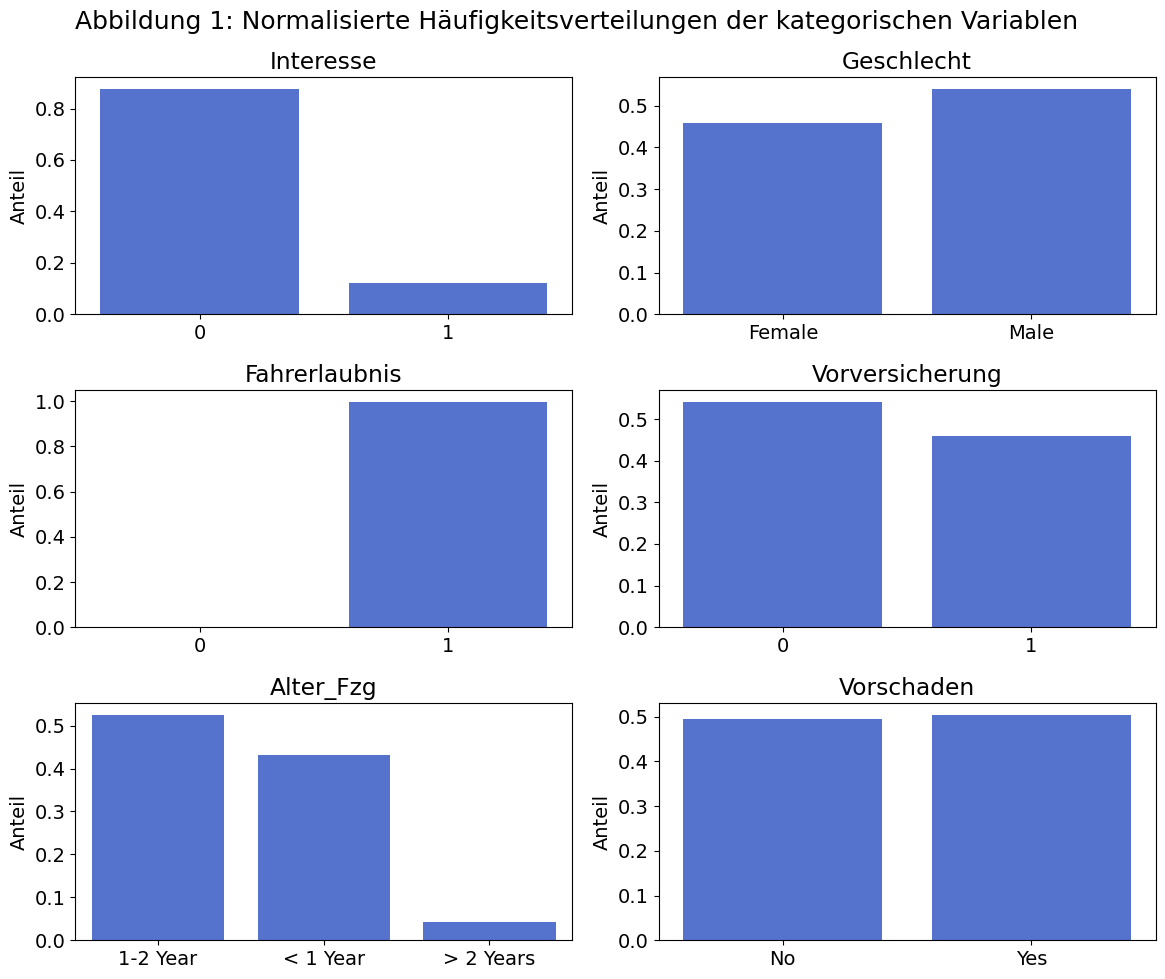

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

features = ['Interesse', 'Geschlecht', 'Fahrerlaubnis', 'Vorversicherung', 'Alter_Fzg', 'Vorschaden']

for ax, var in zip(axes.flatten(), features):
    # Compute normalized value counts
    value_counts = df[var].value_counts(normalize=True)
    
    # Create the barplot
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, color="royalblue")

    # Format the plot
    ax.set_title(var)
    ax.set_xlabel(None)  # Adjust label based on dtype
    ax.set_ylabel("Anteil")
    
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leaves space for the title
fig.suptitle("Abbildung 1: Normalisierte Häufigkeitsverteilungen der kategorischen Variablen", fontsize=18)
plt.show()


### 4.6.2) Numerische Merkmalen

Die folgende Abbildung zeigt die numerischen Merkmale in unseren Datensätzen. In der linken oberen Teilgrafik ist „Alter“ stark linksschief, was darauf hinweist, dass die Mehrheit der Personen in unserem Datensatz eher jünger ist. 

Wir sehen auch, dass „Jahresbeitrag“ extrem rechtsschief ist. Das Diagramm unten rechts untersucht die Beobachtungen im oberen Bereich (definiert als Personen, die mehr als 200.000 EUR/Jahr zahlen). Die relativ gleichmäßige Verteilung im oberen Bereich deutet darauf hin, dass es sich bei diesen statistischen Ausreißern wahrscheinlich nicht um Fehler bei der Dateneingabe handelt.

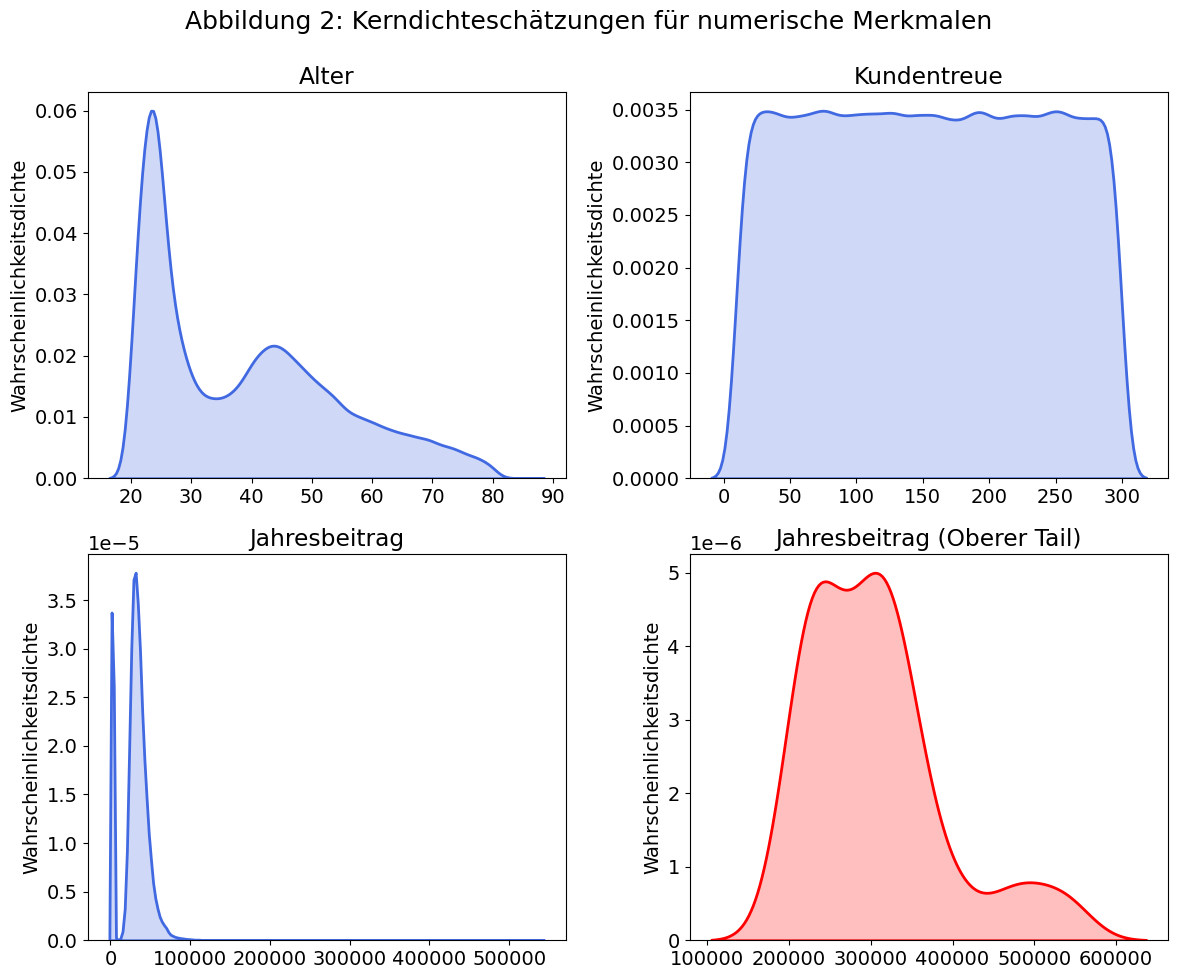

In [18]:
# Define figure and axes for 2x2 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# **Add a global title for the entire figure**
fig.suptitle('Abbildung 2: Kerndichteschätzungen für numerische Merkmalen', fontsize=18)


# List of variables to plot
variables = ['Alter', 'Kundentreue', 'Jahresbeitrag']

# Iterate over the first three variables and create KDE plots
for i, var in enumerate(variables):
    row, col = divmod(i, 2)  # Convert index into row and column for subplot positioning
    sns.kdeplot(df[var], ax=axes[row, col], fill=True, color="royalblue", linewidth=2)
    axes[row, col].set_title(var)
    axes[row, col].set_xlabel(None)
    axes[row, col].set_ylabel("Wahrscheinlichkeitsdichte")

# **Fourth Plot: Analyze Upper Tail of Jahresbeitrag**
sns.kdeplot(df[df['Jahresbeitrag'] > 200_000]['Jahresbeitrag'], ax=axes[1, 1], fill=True, color="red", linewidth=2)
axes[1, 1].set_title("Jahresbeitrag (Oberer Tail)")
axes[1, 1].set_xlabel(None)
axes[1, 1].set_ylabel("Wahrscheinlichkeitsdichte")

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.99])

plt.show()

## 4.7) Bivariate Datenanalyse

### 4.7.1) Bivariate Assoziationen zwischen allen Merkmalen

Die folgende Heatmap zeigt die Beziehung zwischen jedem Merkmal in `df` und allen anderen Merkmalen. Die Messung dieser Beziehung hängt von der Art des Datentyppaares ab:

- Numerisch-Numerisch: [Pearson-Korrelation](https://de.wikipedia.org/wiki/Korrelationskoeffizient_nach_Bravais-Pearson), Wertebereich: -1 bis +1
- Numerisch-Kategorisch: [Correlation Ratio](https://en.wikipedia.org/wiki/Correlation_ratio), Wertebereich: 0 bis +1
- Kategorisch-Kategorisch: [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), Wertebereich: 0 bis +1

Aufgrund der unterschiedlichen Wertebereiche der einzelnen Metriken wird zur besseren Vergleichbarkeit der ***absolute Wert*** verwendet.

In [19]:
corr = associations(df_, figsize=(15, 15), annot=False, multiprocessing=True, plot=False)

Interpretation: Die folgende Abbildung ist eine Heatmap, die die bivariate Beziehung zwischen den verschiedenen Spaltenkombinationen zeigt. Diese Beziehung wird als absoluter Wert dargestellt, so dass jeder Wert zwischen 0 und 1 liegt, wobei höhere Werte (dunklere Quadrate) eine stärkere bivariate Beziehung anzeigen.

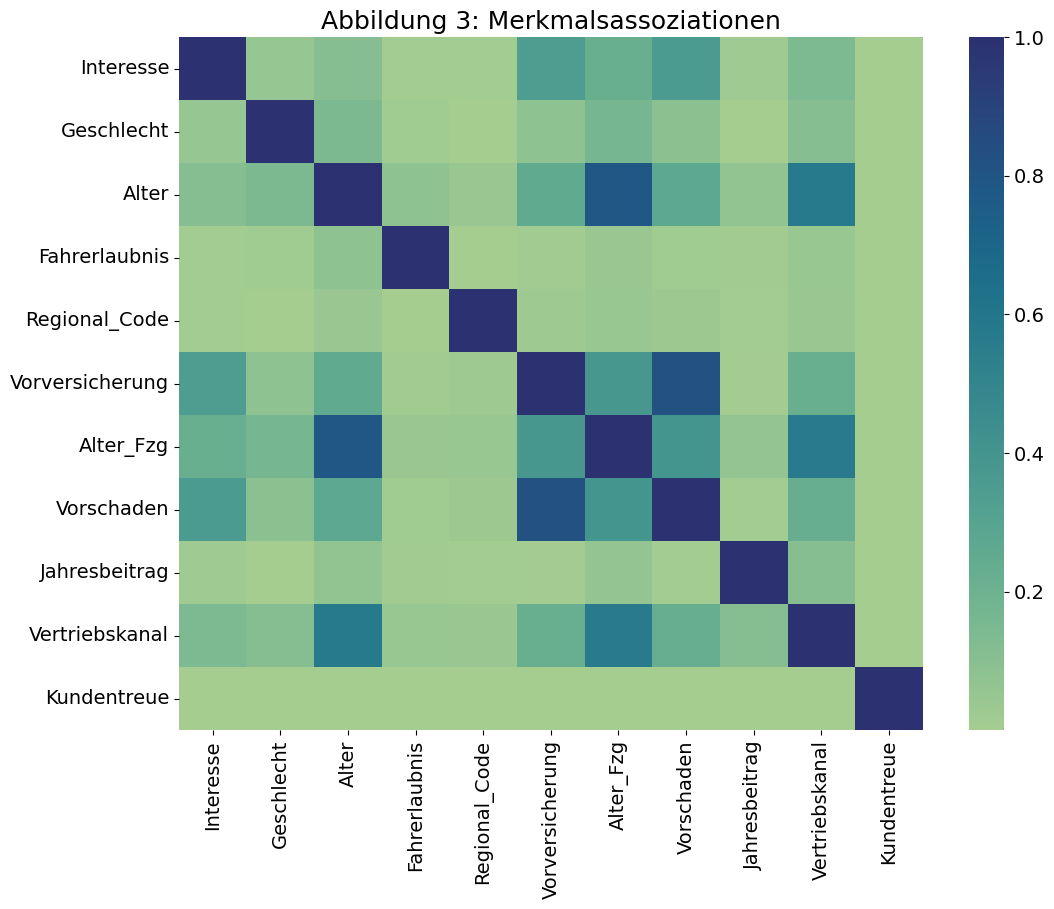

In [20]:
plt.figure(figsize=(12,9))
sns.heatmap(abs(corr['corr']), cmap='crest')
plt.title('Abbildung 3: Merkmalsassoziationen', fontsize=18)
plt.show()

### 4.7.2) Bivariate Merkmalsassoziationen mit der Zielvariable

Die folgende Abbildung 2 zeigt den bivariaten Zusammenhang zwischen den einzelnen Merkmalen und der Ergebnisvariablen „Interesse“ unter Verwendung der oben beschriebenen Maße.

Interpretation: Es zeigt sich, dass die Merkmale "Vorschaden", "Vorversicherung" und "Alter_Fzg" am stärksten mit der Zielgröße korrelieren.

In [21]:
corr_outcome = abs(corr['corr'].iloc[0, 1:]).sort_values(ascending=False)

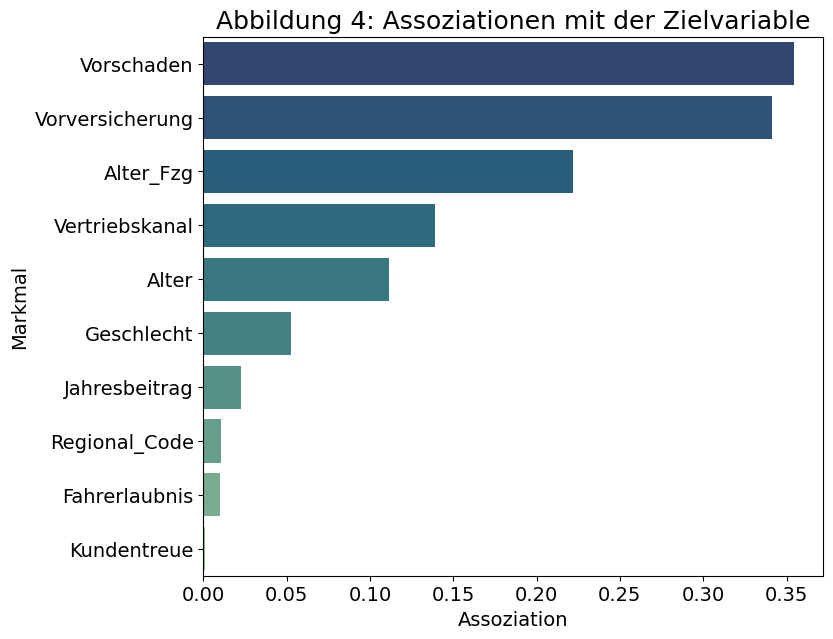

In [22]:
plt.figure(figsize=(8, 7))

num_categories = len(corr_outcome.index)
palette = sns.color_palette("crest", num_categories)[::-1]

sns.barplot(
    x=corr_outcome.values, 
    y=corr_outcome.index, 
    hue=corr_outcome.index,
    palette=palette, 
    legend=False
)
plt.xlabel("Assoziation")
plt.ylabel("Markmal")
plt.title('Abbildung 4: Assoziationen mit der Zielvariable', fontsize=18)
plt.show()

# 5.) Vorverarbeitung für's ML Modell

## 5.1) Stratified Train-Test-Split

Da, wie wir gesehen haben, die Ergebnisvariable klassenungleichgewichtig ist, müssen wir den Datensatz in Trainings- und Testdatensätze stratifizieren, da sonst die Klassen in den Teilmengen ungleichgewichtig sind.

In [23]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0].astype(int)  # eforderlich für Stratifizierung
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

y_train = y_train.astype('category')
y_test = y_test.astype('category')

(304672, 10) (76168, 10)
0.1225842873647726 0.1225842873647726
